In [27]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Creating a stds torch array

In [14]:
class Critic(nn.Module):
    def __init__(self, s_size=33, a_size=4, h_size=None):
        super(Critic, self).__init__()

        if not h_size:
            h_size = 128

        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

critic_nn = Critic()

In [15]:
state_value_estimates = []

for i in range(10):
    state = np.random.randn(1,33)
    state = torch.from_numpy(state).float().unsqueeze(0)
    state_value_estimates.append(critic_nn.forward(state))
    
print(state_value_estimates)

[tensor([[[-0.3292]]]), tensor([[[-0.1346]]]), tensor(1.00000e-02 *
       [[[-7.8843]]]), tensor(1.00000e-02 *
       [[[ 6.5297]]]), tensor(1.00000e-02 *
       [[[-6.8628]]]), tensor(1.00000e-02 *
       [[[ 4.8209]]]), tensor(1.00000e-02 *
       [[[-6.8544]]]), tensor([[[-0.2103]]]), tensor(1.00000e-02 *
       [[[-6.1813]]]), tensor([[[-0.2625]]])]


In [19]:
returns = np.random.randn(10)
print(returns)

[ 0.9553288   0.18883826  1.45361509  0.62463476  0.17646961  0.82248658
  1.03884972 -0.90838555  0.26847422 -0.64523629]


In [20]:
for estimate in state_value_estimates:
    print(estimate.requires_grad)
    print(estimate.grad_fn)

True
True
True
True
True
True
True
True
True
True


In [22]:
returns_with_baseline = returns - np.array([v.clone().squeeze().item() for v in state_value_estimates])
print(returns_with_baseline)

[ 1.28449614  0.32341574  1.53245828  0.55933819  0.24509719  0.77427783
  1.10739401 -0.69808498  0.33028711 -0.38272542]


In [23]:
for estimate in state_value_estimates:
    print(estimate.requires_grad)
    print(estimate.grad_fn)

True
True
True
True
True
True
True
True
True
True


In [24]:
print(torch.cat(state_value_estimates).squeeze())

tensor([-0.3292, -0.1346, -0.0788,  0.0653, -0.0686,  0.0482, -0.0685,
        -0.2103, -0.0618, -0.2625])


In [25]:
for estimate in state_value_estimates:
    print(estimate.requires_grad)
    print(estimate.grad_fn)

True
True
True
True
True
True
True
True
True
True


In [26]:
print(torch.tensor(returns, dtype=torch.float32))

tensor([ 0.9553,  0.1888,  1.4536,  0.6246,  0.1765,  0.8225,  1.0388,
        -0.9084,  0.2685, -0.6452])


# Training A Distributional NN

In [2]:
import matplotlib.pyplot as plt

def plot_scores(losses_moving_avg):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(100, len(losses_moving_avg)+100), losses_moving_avg)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

In [3]:
from torch.distributions import Normal
import torch.optim as optim

class Actor(nn.Module):
    def __init__(self, s_size=33, a_size=4, h_size=None):
        super(Actor, self).__init__()

        if not h_size:
            h_size = 256

        self.fc1 = nn.Linear(s_size, h_size)
        self.fc_means = nn.Linear(h_size, a_size)
        self.fc_log_variances = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        self.means = self.fc_means(x)
        self.log_variances = self.fc_log_variances(x)

        stds = (0.5 * self.log_variances).exp()
        dist = Normal(self.means, stds)
        actions = dist.rsample()

        return actions, dist.log_prob(actions).sum(dim=-1)

Episode 20	Val Loss: 6.39
Episode 40	Val Loss: 3.051
Episode 60	Val Loss: 4.600
Episode 80	Val Loss: 3.03
Episode 100	Val Loss: 5.70
Episode 120	Val Loss: 1.13
Episode 140	Val Loss: 1.76
Episode 160	Val Loss: 3.14
Episode 180	Val Loss: 3.802
Episode 200	Val Loss: 3.050
Episode 220	Val Loss: 1.96
Episode 240	Val Loss: 10.16
Episode 260	Val Loss: 1.529
Episode 280	Val Loss: 4.131
Episode 300	Val Loss: 2.993
Episode 320	Val Loss: 12.70
Episode 340	Val Loss: 3.7944
Episode 360	Val Loss: 2.833
Episode 380	Val Loss: 2.6335
Episode 400	Val Loss: 381.81
Episode 420	Val Loss: 34.9843
Episode 440	Val Loss: 4.2039
Episode 460	Val Loss: 34.305
Episode 480	Val Loss: 44.572
Episode 500	Val Loss: 3.56861


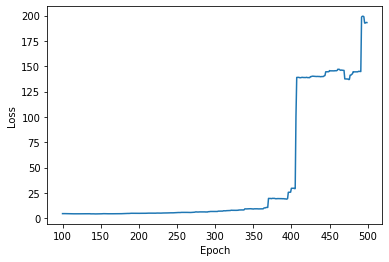

In [6]:
def inspect_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}:\t{np.abs(param.detach().cpu().numpy()).mean():.2f}")

def inspect_grads(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}:\t{np.abs(param.grad.detach().cpu().numpy()).mean():.2f}")
        else:
            print(f"{name}: No gradient computed")

# Instantiate Everything
actor_nn = Actor()
optimizer = optim.Adam(actor_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
fixed_target_tensor = torch.from_numpy(np.random.randn(1,4)).float()

# Run Training Loop
losses = []
losses_moving_avg = []
for episode in range(500):
    # Training Loop
    actor_nn.train()
    
    log_probs = []
    neg_rewards = []
    for t in range(1_000):
        input_tensor = np.random.randn(1,33)
        actions, dist_log_prob = actor_nn.forward(torch.from_numpy(input_tensor).float())
        actions = actions.detach()

        neg_reward = ((actions - fixed_target_tensor)**2).mean().item()
        neg_rewards.append(neg_reward)

        log_probs.append(dist_log_prob)
        
    neg_rewards = (neg_rewards - np.mean(neg_rewards))/(np.std(neg_rewards))
    stack = torch.stack([ log_probs * neg_rewards for log_probs, neg_rewards in zip(log_probs, neg_rewards) ])
    loss = stack.mean()
    loss.backward()
#     if episode >100 and episode%20 == 0:
#         print()
#         print(f'rewards: {neg_rewards}')
#         print()
#         print(f'log_probs: {log_probs}')
#         print()
#         print(f'stack: {stack}')
#         print()
#         print(f'loss: {loss.item()}')
# #         print()
# #         inspect_weights(actor_nn)
# #         print()
# #         inspect_grads(actor_nn)
#         print('----------------')
#         print()
#         print()
    optimizer.step()
    optimizer.zero_grad()

    # Validation Loop
    actor_nn.eval()
    
    input_tensor = np.random.randn(1,33)
    actions, _ = actor_nn.forward(torch.from_numpy(input_tensor).float())
    
    loss = loss_fn(actions, fixed_target_tensor)
    losses.append(loss.item())
    if episode >= 100:
        losses_moving_avg.append(np.mean(losses[episode-100:episode]))
    
    print(f'\rEpisode {episode+1}\tVal Loss: {loss.item():.2f}', end='', flush=True)
    if ((episode+1) % 20 == 0):
        print(f'\rEpisode {episode+1}\tVal Loss: {loss.item():.2f}')
        
plot_scores(losses_moving_avg)

Episode 100	Val Loss: 1.84
Episode 200	Val Loss: 0.98
Episode 300	Val Loss: 0.32
Episode 400	Val Loss: 1.00
Episode 500	Val Loss: 0.12
Episode 600	Val Loss: 1.40
Episode 700	Val Loss: 0.52
Episode 800	Val Loss: 0.29
Episode 900	Val Loss: 0.19
Episode 1000	Val Loss: 0.16


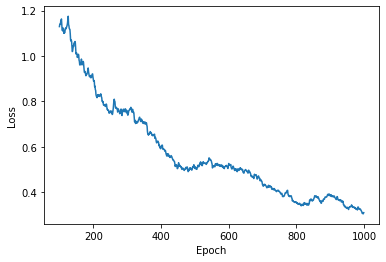

In [7]:
def inspect_weights(model):
    for name, param in model.named_parameters():
        print(f"{name}:\t{np.abs(param.detach().cpu().numpy()).mean():.2f}")

def inspect_grads(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}:\t{np.abs(param.grad.detach().cpu().numpy()).mean():.2f}")
        else:
            print(f"{name}: No gradient computed")

# Instantiate Everything
actor_nn = Actor()
optimizer = optim.Adam(actor_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
fixed_target_tensor = torch.from_numpy(np.random.randn(1,4)).float()

# Run Training Loop
losses = []
losses_moving_avg = []
for episode in range(1_000):
    actor_nn.train()
    
    input_tensor = np.random.randn(1,33)
    actions, _ = actor_nn.forward(torch.from_numpy(input_tensor).float())
    
    loss = loss_fn(actions, fixed_target_tensor)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if episode >= 100:
        losses_moving_avg.append(np.mean(losses[episode-100:episode]))
    
    print(f'\rEpisode {episode+1}\tVal Loss: {loss.item():.2f}', end='', flush=True)
    if ((episode+1) % 100 == 0):
        print(f'\rEpisode {episode+1}\tVal Loss: {loss.item():.2f}')
        
plot_scores(losses_moving_avg)

# Test the Loss Fn

In [ ]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64', no_graphics=True),
agent = Agent(state_size=33, action_size=4, seed=0),

In [ ]:
brain_name = env.brain_names[0]

for t in range(max_t):
    action = agent.act(state)

    env_info = env.step(action)[brain_name]
    next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
    agent.rewards.append(reward)

    state = next_state
    score += reward

    if done:
        break

# Normalizing Rewards

In [93]:
rewards = np.array([[0.1, 0, 0, 0, 0.1], [0, 0, 0.1, 0.1, 0.1]])
print(rewards.std())
print(rewards.mean())
print((rewards - rewards.mean()) / (rewards.std() + 1e-5) )
# print((np.array(rewards) - 0.05)*2.0)

0.05000000000000001
0.05
[[ 0.99980004 -0.99980004 -0.99980004 -0.99980004  0.99980004]
 [-0.99980004 -0.99980004  0.99980004  0.99980004  0.99980004]]


# Scores Printing

In [72]:
import time

for i in range(1, 21):
    if i % 5 == 0:
        print(f"\rCheckpoint: {i}/20")  # Permanent line with newline
    else:
        print(f"\rProgress: {i}/20", end="", flush=True)  # Overwrite line
    time.sleep(0.2)
print()

Checkpoint: 5/20
Checkpoint: 10/20
Checkpoint: 15/20
Checkpoint: 20/20



# Calculating Returns

In [76]:
def calculate_returns(GAMMA, rewards):
    discounts = np.array([GAMMA**i for i in range(len(rewards))] + [0.0])
    
    intermediate = (rewards[:,1-1:]*discounts[:-1]).sum(-1)
    print(intermediate)
    
    returns = np.array([
        (rewards[:,i-1:]*discounts[:-i]).sum(-1)
        for i in range(1, len(rewards)+1)
    ]).transpose()
    
    return returns

In [77]:
GAMMA = 0.99
rewards = np.array([[0.0, 0.1, 0.2, 0.3, 0.4]]*5)
print(rewards.shape)
print(rewards[:,2:])
print(f'Calculated: {calculate_returns(GAMMA, rewards)}')

print(f'Expected: {np.array([0.9703481039999999, 0.9801496000000001, 0.88904, 0.696, 0.4])}')    

(5, 5)
[[0.2 0.3 0.4]
 [0.2 0.3 0.4]
 [0.2 0.3 0.4]
 [0.2 0.3 0.4]
 [0.2 0.3 0.4]]
[0.9703481 0.9703481 0.9703481 0.9703481 0.9703481]
Calculated: [[0.9703481 0.9801496 0.88904   0.696     0.4      ]
 [0.9703481 0.9801496 0.88904   0.696     0.4      ]
 [0.9703481 0.9801496 0.88904   0.696     0.4      ]
 [0.9703481 0.9801496 0.88904   0.696     0.4      ]
 [0.9703481 0.9801496 0.88904   0.696     0.4      ]]
Expected: [0.9703481 0.9801496 0.88904   0.696     0.4      ]


In [62]:
returns

[0.9703481039999999, 0.9801496000000001, 0.88904, 0.696, 0.4]

In [64]:
1.0*0.0 + 0.99*0.1 + 0.9801*0.2 + 0.970299*0.3 + 0.96059601*0.4

0.9703481039999999

In [65]:
1.0*0.1 + 0.99*0.2 + 0.9801*0.3 + 0.970299*0.4

0.9801496000000001

In [66]:
1.0*0.2 + 0.99*0.3 + 0.9801*0.4

0.88904

In [67]:
1.0*0.3 + 0.99*0.4

0.696

In [68]:
1.0*0.4

0.4

# Point-wise mult of torch.Tensor and np.array

In [193]:
t = [torch.Tensor([e]) for e in [0.0, 0.1, 0.2, 0.3, 0.4]]
t = torch.stack(t)
n = np.array([0.99**i for i in range(len(t))])
print(n)

[1.         0.99       0.9801     0.970299   0.96059601]


In [194]:
print((t*torch.Tensor(n)).sum())

tensor(4.9010)
